In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import vanillaWH
import vanillaWH_tools

%matplotlib inline

In [3]:
# initial conditions

# particle array as [x, y, z, vx, vy, vz, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])
p2 = np.array([2., 0., 0., 0., 0.7, 0., 1e-3])
sim = np.stack([p0, p1, p2])

sim = vanillaWH_tools.move_to_com(sim)

timestep = 0.01
N_steps = 10000

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((3, 3, N_steps)) # [object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim[:,0], sim[:,1]

start = time.time()

simj = vanillaWH_tools.inertial_to_jacobi(sim)

for i in range(N_steps):
    
    # drift
    simj = vanillaWH.drift(simj, sim, object_num = 1, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 2, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)
    
    # kick
    simj = vanillaWH.kick(simj, sim, h=timestep)
    
    # drift
    simj = vanillaWH.drift(simj, sim, object_num = 1, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 2, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)

    E = vanillaWH_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim[:,0]
    orbit_soln[:, 1, i] = sim[:,1]
    orbit_soln[:, 2, i] = sim[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 5.2 s


In [4]:
sim = rebound.Simulation()
sim.integrator='whfast'
sim.dt = timestep
sim.add(m=1.)
sim.add(m=1e-3, x=1., vy=1.)
sim.add(m=1e-3, x=2., vy=0.7)

sim.move_to_com()

energy_error_reb = np.zeros(N_steps) 
E0 = sim.calculate_energy()

orbit_soln_rebound = np.zeros((3, 3, N_steps))
diff0, diff1, diff2 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)

for i in range(N_steps):
    sim.step() 
    
    E = sim.calculate_energy()
    energy_error_reb[i] = np.abs((E-E0)/E0)
    
    orbit_soln_rebound[0,:,i] = sim.particles[0].x, sim.particles[0].y, sim.particles[0].z
    orbit_soln_rebound[1,:,i] = sim.particles[1].x, sim.particles[1].y, sim.particles[1].z
    orbit_soln_rebound[2,:,i] = sim.particles[2].x, sim.particles[2].y, sim.particles[2].z
    
    dx0 = orbit_soln_rebound[0,0,i]-orbit_soln[0,0,i]
    dy0 = orbit_soln_rebound[0,1,i]-orbit_soln[0,1,i]
    dz0 = orbit_soln_rebound[0,2,i]-orbit_soln[0,2,i]
    diff0[i] = np.sqrt(dx0**2 + dy0**2 + dz0**2)
    
    dx1 = orbit_soln_rebound[1,0,i]-orbit_soln[1,0,i]
    dy1 = orbit_soln_rebound[1,1,i]-orbit_soln[1,1,i]
    dz1 = orbit_soln_rebound[1,2,i]-orbit_soln[1,2,i]
    diff1[i] = np.sqrt(dx1**2 + dy1**2 + dz1**2)
    
    dx2 = orbit_soln_rebound[2,0,i]-orbit_soln[2,0,i]
    dy2 = orbit_soln_rebound[2,1,i]-orbit_soln[2,1,i]
    dz2 = orbit_soln_rebound[2,2,i]-orbit_soln[2,2,i]
    diff2[i] = np.sqrt(dx2**2 + dy2**2 + dz2**2)


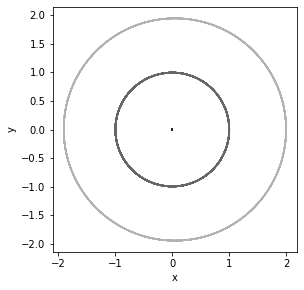

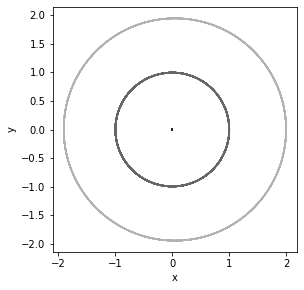

In [5]:
plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], alpha=0.9, c='black')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], alpha=0.6, c='black')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], alpha=0.3, c='black')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
#plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln_rebound[0,0], orbit_soln_rebound[0,1], alpha=0.9, c='black')
plt.plot(orbit_soln_rebound[1,0], orbit_soln_rebound[1,1], alpha=0.6, c='black')
plt.plot(orbit_soln_rebound[2,0], orbit_soln_rebound[2,1], alpha=0.3, c='black')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
#plt.legend(loc='lower right')
plt.show()


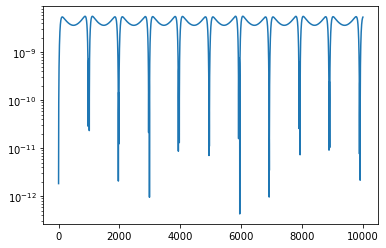

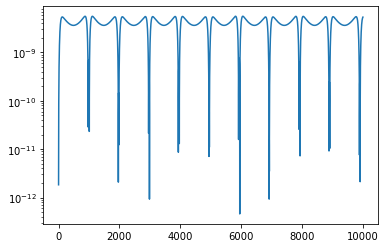

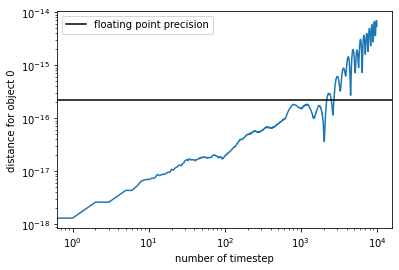

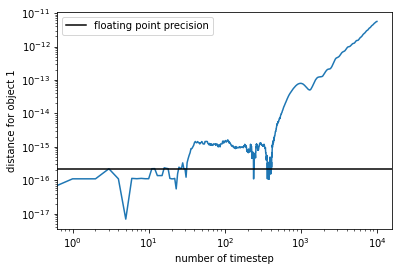

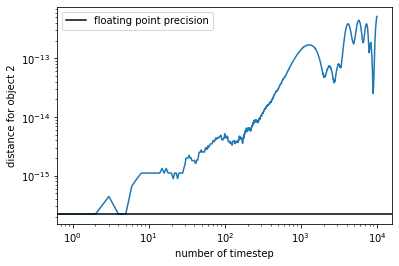

In [6]:
plt.plot(energy_error)
plt.yscale('log')
plt.show()

plt.plot(energy_error_reb)
plt.yscale('log')
plt.show()

plt.plot(diff0)
plt.axhline(sys.float_info.epsilon, label='floating point precision', c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of timestep')
plt.ylabel('distance for object 0')
plt.legend()
plt.show()

plt.plot(diff1)
plt.axhline(sys.float_info.epsilon, label='floating point precision', c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of timestep')
plt.ylabel('distance for object 1')
plt.legend()
plt.show()

plt.plot(diff2)
plt.axhline(sys.float_info.epsilon, label='floating point precision', c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of timestep')
plt.ylabel('distance for object 2')
plt.legend()
plt.show()

In [ ]:
# particle array as [rx, ry, vx, vy, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])
p2 = np.array([2., 0., 0., 0., 0.7, 0., 1e-3])
sim = np.stack([p0, p1, p2])

sim = vanillaWH_tools.move_to_com(sim)

print('sim before transform', sim[:,:5])

simj = vanillaWH_tools.inertial_to_jacobi(sim)

print('simj after transform', simj[:,:5])

sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)

print('sim after transform back', sim[:,:5])